In [1]:
import numpy as np
import pandas as pd
import re
import sklearn.metrics.pairwise as smp
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
bggdata_df = pd.read_pickle('datasources/BGG_FINAL.pkl')

In [3]:
bggdata_df.columns

Index(['game_rank', 'geek_rating', 'avg_rating', 'num_raters', 'game_name',
       'game_year', 'bgg_url', 'reimpl0', 'reimpl0href', 'ranks', 'avgrating',
       'titleinfo', 'gameplayinfo', 'gamecredits', 'ftr_title', 'ftr_descr',
       'gamedscription', 'rnkoverall', 'rnkthematic', 'rnkstrategy',
       'shortsummary', 'numplayersmin', 'numplayersmax', 'gamedurmin',
       'gamedurmax', 'agemin', 'gameweight', 'designer', 'artist', 'publisher',
       'gametype', 'gamecategory', 'gamemechanisms', 'gamefamily', 'rnkwar',
       'rnkcustomizable', 'rnkfamily', 'rnkabstract', 'rnkparty',
       'rnkchildren's', 'rnkamiga', 'rnkcommodore64', 'rnkarcade',
       'rnkatariST'],
      dtype='object')

### Get game word2vec

In [4]:
from gensim.models import Word2Vec
bgg_model = Word2Vec.load('datasources/bgg_w2v_model.bin')
words = list(bgg_model.wv.vocab)
print(words[:11])

['gloomhaven', 'is', 'a', 'game', 'of', 'tactical', 'combat', 'in', 'persistent', 'world', 'shifting']


# Create vectors for all boardgames

## Create game description document sanitizer:

In [5]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english')) 

def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text


def sanitize_text(df, text_field, new_text_field_name):
    stop_words = set(stopwords.words('english')) 

    # CLEAN
    df[new_text_field_name] = df[text_field].str.lower()

    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem)) 

    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))

    # DISINFECT - aka TOKENIZATION
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: word_tokenize(elem))

    # Remove STOP words
    for ii in df.index:
        try:
            currii=ii
            #df.loc[ii,new_text_field_name] = [w for w in df.loc[ii,new_text_field_name] if not w in stop_words]
        except:
            print('this ii: {}'.format(ii))
        
    # CAUTERIZE - aka LEMMATIZATION
    #df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: word_lemmatizer(elem))
    
    return df
    

In [10]:
testdf = pd.DataFrame({'desc':bggdata_df.loc[[0, 126, 151],'gamedscription']})
testdf = sanitize_text(testdf,'desc','desc2')
testdf.shape

(3, 2)

## Get average vectors for each game description

In [11]:
gamedocvects_df = pd.DataFrame({})

for currdoc in testdf['desc2']:
    numw = len(currdoc)
    docvect_df = pd.DataFrame({})
    for w in range(0,numw): # Over all words in the doc
        if currdoc[w] in words:
            docvect_df = pd.concat((docvect_df,pd.DataFrame(bgg_model.wv[currdoc[w]])),axis=1)
    gamedocvects_df = pd.concat((gamedocvects_df,docvect_df.mean(axis=1)),axis=1)
    

### Sanity check

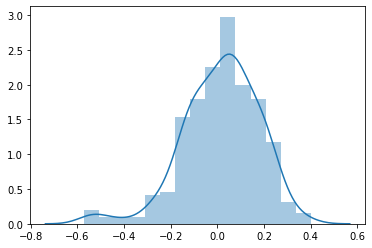

In [12]:
sns.distplot(np.ravel(gamedocvects_df))

In [13]:
gamedocvects = np.array(gamedocvects_df).T # vectors, 1 per document: each ROW is a game
gamesimilarities = smp.cosine_similarity(gamedocvects)
gamesimilarities_df = pd.DataFrame(gamesimilarities,columns=list(bggdata_df.loc[testdf.index,'game_name']),index=list(bggdata_df.loc[testdf.index,'game_name']))

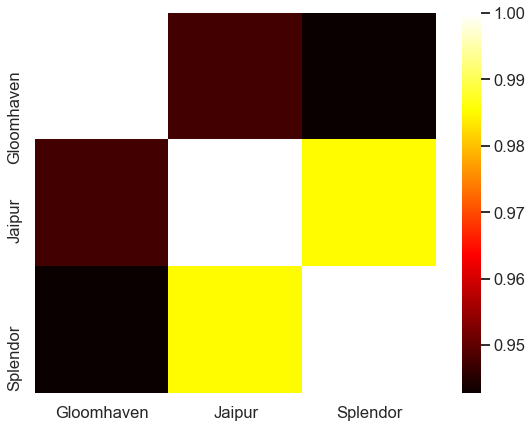

In [18]:
sns.set(context='talk')
f,a = plt.subplots(1,1,figsize=(9,7))
ax = sns.heatmap(gamesimilarities_df, cmap='hot')

# Get similarities for ALL GAMES 
### Select only games with desc lens >N
### N >= 200

In [90]:
N=200
allgamesdesc_df = pd.DataFrame({'idx':bggdata_df.index,'gamename':bggdata_df['game_name'],'desc':bggdata_df['gamedscription']})
allgamesdesc_df = allgamesdesc_df[allgamesdesc_df['desc'].str.len()>=N]

In [91]:
allgamesdesc_df.shape

(18561, 3)

In [109]:
dum_df = sanitize_text(pd.DataFrame(allgamesdesc_df['desc']),'desc','desc_clean')

In [110]:
allgamesdesc_df['desc_clean'] = dum_df['desc_clean']

In [112]:
allgamesdesc_df.head(3)

,idx,gamename,desc,desc_clean
0,0,Gloomhaven,Gloomhaven is a game of Euro-inspired tactical...,"[gloomhaven, is, a, game, of, euroinspired, ta..."
1,1,Pandemic Legacy: Season 1,Pandemic Legacy is a co-operative campaign gam...,"[pandemic, legacy, is, a, cooperative, campaig..."
2,2,Terraforming Mars,"In the 2400s, mankind begins to terraform the ...","[in, the, s, mankind, begins, to, terraform, t..."


In [114]:
allgamedocvects_df = pd.DataFrame({})

for currdoc in allgamesdesc_df['desc_clean']:
    numw = len(currdoc)
    docvect_df = pd.DataFrame({})
    for w in range(0,numw): # Over all words in the doc
        if currdoc[w] in words:
            docvect_df = pd.concat((docvect_df,pd.DataFrame(bgg_model.wv[currdoc[w]])),axis=1)
    allgamedocvects_df = pd.concat((allgamedocvects_df,docvect_df.mean(axis=1)),axis=1)
    

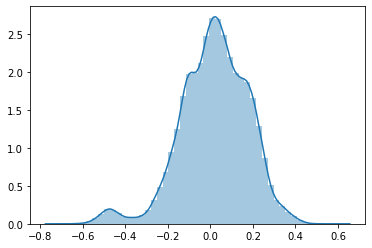

In [115]:
sns.distplot(np.ravel(allgamedocvects_df))

In [116]:
allgamedocvects = np.array(allgamedocvects_df).T # Transpose so each ROW is a game.
print('Each ROW is a game; shape of matrix is: {}'.format(allgamedocvects.shape))

Each ROW is a game; shape of matrix is: (18561, 100)


In [117]:
allgamesimilarities = smp.cosine_similarity(allgamedocvects)

In [151]:
allgamesimilarities.shape

(18561, 18561)

In [120]:
allgamesimilarities_df = pd.DataFrame(allgamesimilarities,columns=list(allgamesdesc_df['gamename']),index=list(allgamesdesc_df['gamename']))

In [122]:
# SAVE DATA
#allgamesimilarities_df.to_csv('BGG_GameSimilarityMatrix.csv')
#allgamesimilarities_df.to_pickle('BGG_GameSimilarityMatrix.pkl')

In [159]:
finalgamelist_df = pd.DataFrame({'idx':allgamesdesc_df.index,'gamename':np.array(list(allgamesdesc_df['gamename']))})

In [160]:
# SAVE DATA
#finalgamelist_df.to_pickle('BGG_GameSimilarityKey.pkl')
#finalgamelist_df.to_csv('BGG_GameSimilarityKey.csv')

## Test some random sets

In [125]:
allgamesimilarities_df.shape

(18561, 18561)

In [152]:
ii = np.append(0,np.random.randint(0,18560,6))

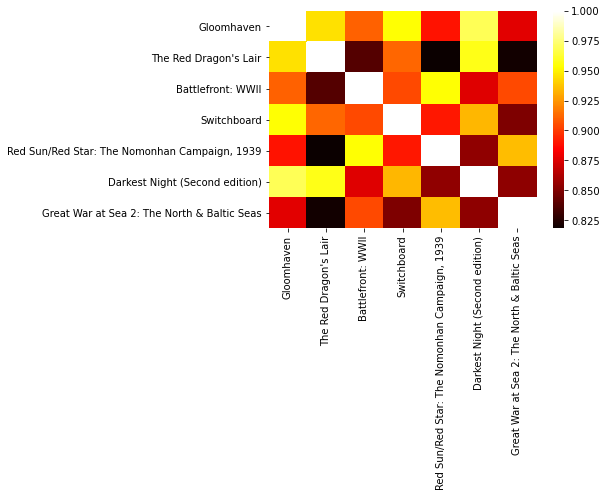

In [153]:
ax = sns.heatmap(allgamesimilarities_df.iloc[ii,ii], cmap='hot')

In [154]:
list(allgamesimilarities_df.index[ii])

['Gloomhaven',
 "The Red Dragon's Lair",
 'Battlefront: WWII',
 'Switchboard',
 'Red Sun/Red Star: The Nomonhan Campaign, 1939',
 'Darkest Night (Second edition)',
 'Great War at Sea 2: The North & Baltic Seas']

In [158]:
finalgamelist.loc[ii,'gamename']

0                                           Gloomhaven
16715                            The Red Dragon's Lair
8994                                 Battlefront: WWII
13390                                      Switchboard
13884    Red Sun/Red Star: The Nomonhan Campaign, 1939
2373                    Darkest Night (Second edition)
7660       Great War at Sea 2: The North & Baltic Seas
Name: gamename, dtype: object

# Find game most similar to...

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [446]:
def get_similar_games(mygamename):
    gamename_matchlist = [fuzz.token_sort_ratio(x,mygamename) for x in finalgamelist_df['gamename']]
    possiblegame_idx  = [i for i, x in enumerate(gamename_matchlist) if x == max(gamename_matchlist)]
    possiblegame_idx = possiblegame_idx[0] # Get first, make it number
    possiblegame_name = list(finalgamelist_df.loc[finalgamelist_df['idx']==possiblegame_idx,'gamename'])[0]
    print('Best match: {}'.format(possiblegame_name))

    mygamevect = list(allgamesimilarities_df.loc[:,possiblegame_name])
    mygamevect_df = pd.DataFrame({'gamename':allgamesimilarities_df.index,'cosinesimilarity':mygamevect})
    mygamevect_df.sort_values(by='cosinesimilarity',inplace=True,ascending=False)
    
    return mygamevect_df

In [447]:
mygamename='codenms'
mygamevect_df = get_similar_games(mygamename)
mygamevect_df.head(11)

Best match: Codenames


,gamename,cosinesimilarity
77,Codenames,1.000000
1672,Codenames: Deep Undercover,0.991408
11435,Codenames: The Simpsons,0.983244
3892,Codenames: Marvel,0.981780
6178,Final Touch,0.979883
11263,Affinity,0.978917
14891,Women vs. Men Alias,0.977765
105,Decrypto,0.977177
7934,Buzzword,0.977151
9649,Spy Alley,0.977005
